In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import random
import matplotlib.pyplot as plt
import keras
from keras.layers import LSTM, Dropout, Dense, Flatten, Input, LeakyReLU, BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.utils import plot_model
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import graphviz
import pydot

In [2]:
df = pd.read_csv("C:\\Users\\Kevin\\Desktop\\Data3001\datascience-cis-2022.csv")
df['time'] = pd.to_datetime(df['time'], unit='ns')

In [3]:
df_dev1 = df[df["device_mac"] == "bd:0d:8e:c5"]
df_dev1.set_index('time', inplace=True)

In [42]:
df_dev1.head(50)

,FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount,ToLocalUDPPort67IP255.255.255.255/32ByteCount
time,,,,
2022-09-02 00:24:59.417,0,395738,0,0
2022-09-02 00:25:59.386,0,415242,0,0
2022-09-02 00:26:59.365,0,409825,0,0
2022-09-02 00:27:59.422,0,393513,0,0
2022-09-02 00:28:59.461,0,395554,1400,906
2022-09-02 00:29:59.399,0,388416,1400,906
2022-09-02 00:30:59.533,0,398128,1400,906
2022-09-02 00:31:59.428,0,392916,0,0
2022-09-02 00:32:59.459,0,411650,0,0


In [4]:
df_dev1 = df_dev1[['FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
                   'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
                   'FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount',
                   'ToLocalUDPPort67IP255.255.255.255/32ByteCount']]

In [14]:
df_dev1.shape

(19065, 4)

In [5]:
df_50min = df_dev1['2022-09-02 00:24:59.417':'2022-09-02 01:15:00.371']

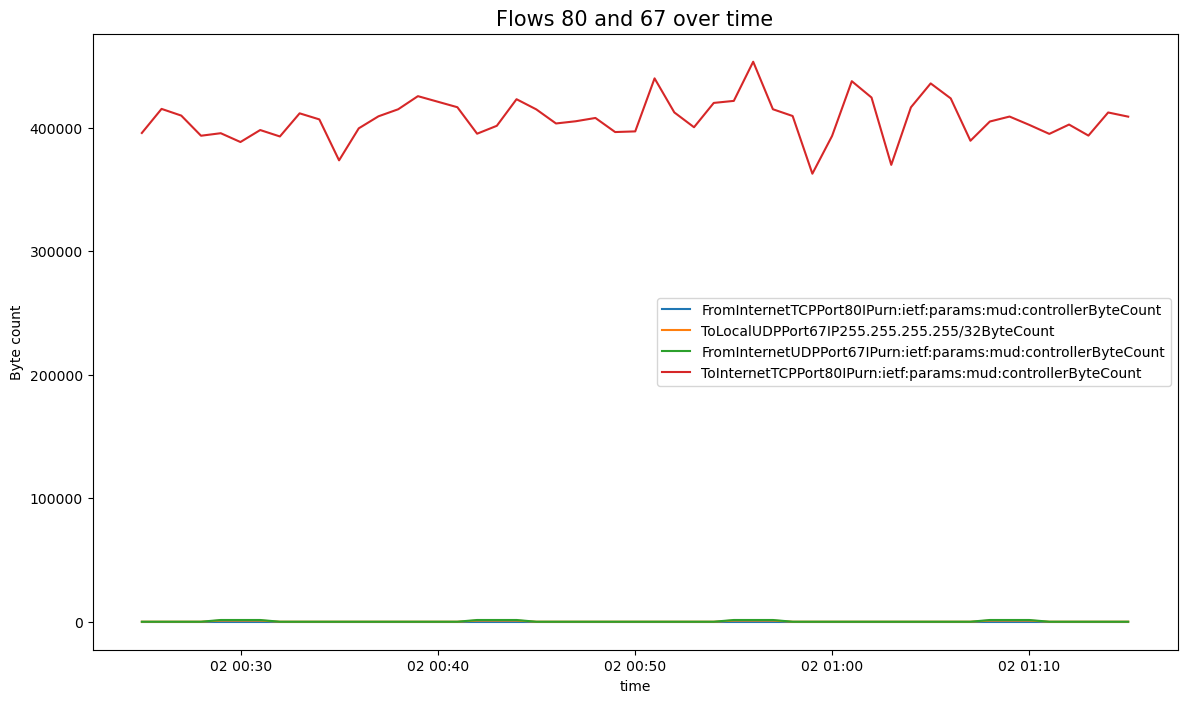

In [42]:
import seaborn as sns
plt.figure(figsize=(14,8))
plt.title("Flows 80 and 67 over time", fontdict={"fontsize": 15})

lines = {'FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
         'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
         'FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount',
         'ToLocalUDPPort67IP255.255.255.255/32ByteCount'}

for line in lines:
    ax = sns.lineplot(x='time', y=line, data=df_50min)

plt.ylabel('Byte count')
plt.legend(lines)

In [6]:
train_size = int(0.8 * len(df_dev1))
test_size = len(df_dev1) - train_size
train, test = df_dev1.iloc[0:train_size], df_dev1.iloc[train_size:len(df_dev1)]

In [17]:
train.head(20)

,FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount,ToLocalUDPPort67IP255.255.255.255/32ByteCount
time,,,,
2022-09-02 00:24:59.417,0,395738,0,0
2022-09-02 00:25:59.386,0,415242,0,0
2022-09-02 00:26:59.365,0,409825,0,0
2022-09-02 00:27:59.422,0,393513,0,0
2022-09-02 00:28:59.461,0,395554,1400,906
2022-09-02 00:29:59.399,0,388416,1400,906
2022-09-02 00:30:59.533,0,398128,1400,906
2022-09-02 00:31:59.428,0,392916,0,0
2022-09-02 00:32:59.459,0,411650,0,0


In [22]:
test.head(20)

,FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount,ToLocalUDPPort67IP255.255.255.255/32ByteCount
time,,,,
2022-09-13 04:47:01.703,0,386150,0,0
2022-09-13 04:48:01.651,0,399840,0,0
2022-09-13 04:49:01.687,0,405904,0,0
2022-09-13 04:50:01.718,0,382403,0,0
2022-09-13 04:51:01.709,0,420315,0,0
2022-09-13 04:53:01.636,0,421033,0,0
2022-09-13 04:54:01.706,0,413209,0,0
2022-09-13 04:55:01.608,0,426339,0,0
2022-09-13 04:56:01.691,0,387965,0,0


In [23]:
print(train.shape, test.shape)

(15252, 4) (3813, 4)


In [7]:
def batch(X, y, time_steps=1):
    series_X, series_Y = [], []
    for i in range(len(X) - time_steps):
        new = X.iloc[i: (i + time_steps)].to_numpy()
        series_X.append(new)
        series_Y.append(y.iloc[i + time_steps])
    return np.array(series_X), np.array(series_Y)

In [8]:
TIME = 15

X_train, y_train = batch(train, train['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)
X_test, y_test = batch(test, test['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)

In [33]:
model = keras.Sequential()
model.add(LSTM(units = 64, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units = 32, return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(32, activation='relu'))
model.add(Dense(12, activation='sigmoid'))
model.compile(optimizer="adam", loss="mse")

In [10]:
history = model.fit(X_train, y_train,
                    epochs = 50,
                    batch_size = 64,
                    validation_split = 0.1,
                    shuffle = False)

Epoch 1/50
215/215 [==============================] - 6s 13ms/step - loss: 178703106048.0000 - val_loss: 182317678592.0000
Epoch 2/50
215/215 [==============================] - 2s 8ms/step - loss: 178703106048.0000 - val_loss: 182317678592.0000
Epoch 3/50
215/215 [==============================] - 2s 9ms/step - loss: 178703106048.0000 - val_loss: 182317678592.0000
Epoch 4/50
215/215 [==============================] - 2s 8ms/step - loss: 178703106048.0000 - val_loss: 182317678592.0000
Epoch 5/50
215/215 [==============================] - 2s 8ms/step - loss: 178703106048.0000 - val_loss: 182317678592.0000
Epoch 6/50
215/215 [==============================] - 2s 9ms/step - loss: 178703106048.0000 - val_loss: 182317678592.0000
Epoch 7/50
215/215 [==============================] - 2s 9ms/step - loss: 178703106048.0000 - val_loss: 182317678592.0000
Epoch 8/50
215/215 [==============================] - 2s 9ms/step - loss: 178703106048.0000 - val_loss: 182317678592.0000
Epoch 9/50
215/215 [===

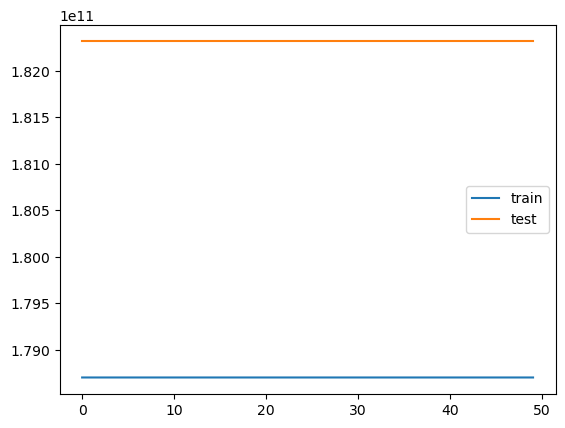

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [11]:
normalised_df = (df_dev1-df_dev1.min())/(df_dev1.max()-df_dev1.min())

In [50]:
normalised_df.head(50)

,FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount,FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount,ToLocalUDPPort67IP255.255.255.255/32ByteCount
time,,,,
2022-09-02 00:24:59.417,0.0,0.272425,0.0,0.0
2022-09-02 00:25:59.386,0.0,0.285851,0.0,0.0
2022-09-02 00:26:59.365,0.0,0.282122,0.0,0.0
2022-09-02 00:27:59.422,0.0,0.270893,0.0,0.0
2022-09-02 00:28:59.461,0.0,0.272298,0.5,0.5
2022-09-02 00:29:59.399,0.0,0.267384,0.5,0.5
2022-09-02 00:30:59.533,0.0,0.274070,0.5,0.5
2022-09-02 00:31:59.428,0.0,0.270482,0.0,0.0
2022-09-02 00:32:59.459,0.0,0.283379,0.0,0.0


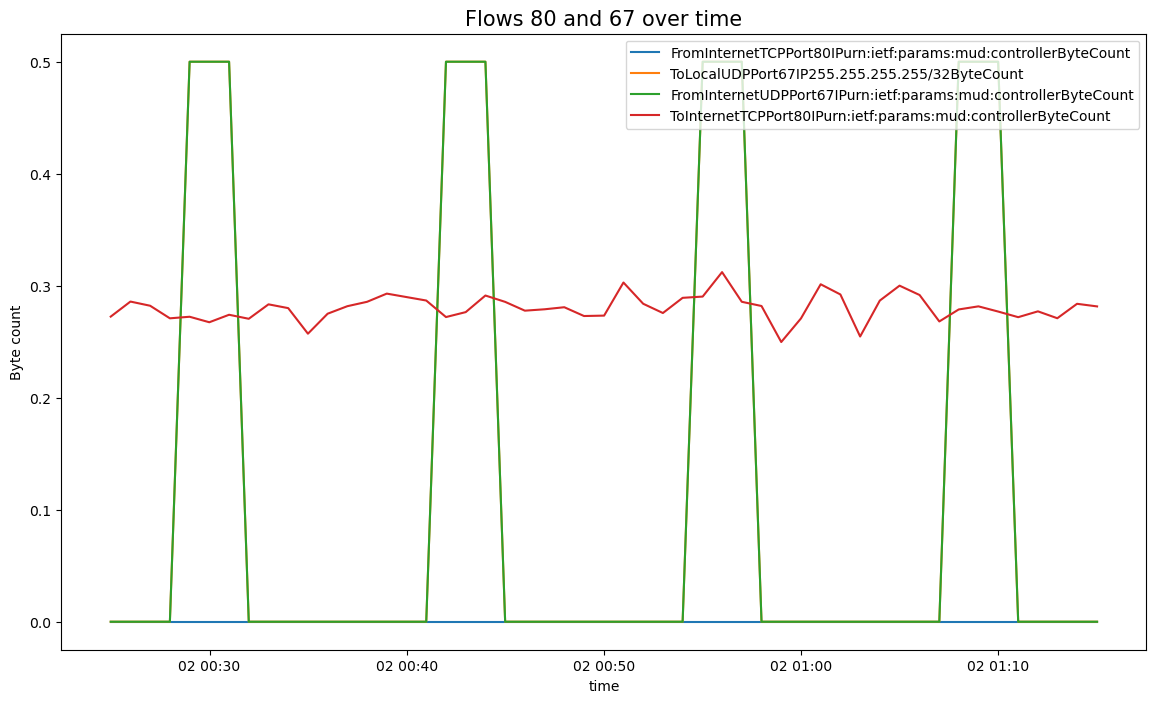

In [43]:
normalised_df_50min = normalised_df['2022-09-02 00:24:59.417':'2022-09-02 01:15:00.371']
plt.figure(figsize=(14,8))
plt.title("Flows 80 and 67 over time", fontdict={"fontsize": 15})

lines = {'FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
         'ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount',
         'FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount',
         'ToLocalUDPPort67IP255.255.255.255/32ByteCount'}

for line in lines:
    ax = sns.lineplot(x='time', y=line, data=normalised_df_50min)

plt.ylabel('Byte count')
plt.legend(lines)

In [44]:
train_2, test_2 = normalised_df.iloc[0:train_size], normalised_df.iloc[train_size:len(df_dev1)]
X_train_2, y_train_2 = batch(train_2, train_2['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)
X_test_2, y_test_2 = batch(test_2, test_2['ToInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)

In [34]:
history_to80 = model.fit(X_train_2, y_train_2,
                    epochs = 50,
                    batch_size = 62,
                    validation_split = 0.1,
                    shuffle = False)

Epoch 1/50
222/222 [==============================] - 7s 13ms/step - loss: 0.0089 - val_loss: 0.0034
Epoch 2/50
222/222 [==============================] - 2s 9ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 3/50
222/222 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 4/50
222/222 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 5/50
222/222 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 6/50
222/222 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 7/50
222/222 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 8/50
222/222 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 9/50
222/222 [==============================] - 2s 9ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 10/50
222/222 [==============================] - 2s 10ms/step - loss: 0.0028 - val_loss: 0.00

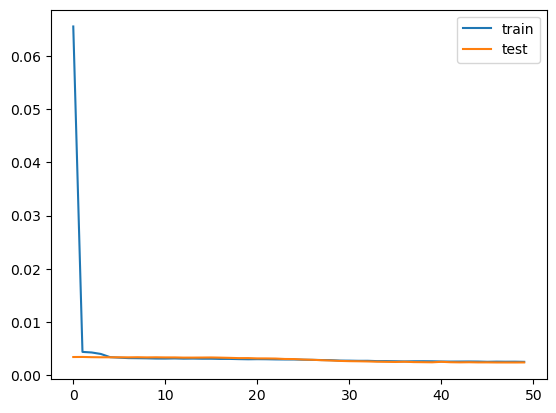

In [48]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

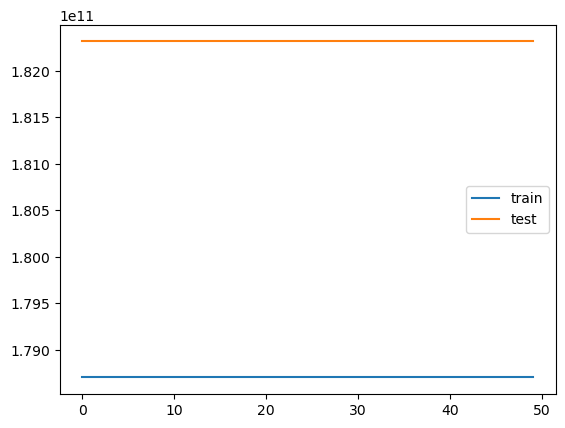

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [51]:
y_pred = model.predict(X_test_2)

119/119 [==============================] - 1s 3ms/step


In [46]:
y_pred_sm = model.predict(X_test_2)

119/119 [==============================] - 0s 3ms/step


In [47]:
y_pred_sm

array([[0.27861825, 0.2786186 , 0.27861795, ..., 0.27862236, 0.27862528,
        0.27861455],
       [0.27940032, 0.27940118, 0.27939987, ..., 0.2794024 , 0.279409  ,
        0.2793971 ],
       [0.28227788, 0.28227773, 0.2822768 , ..., 0.2822775 , 0.28228503,
        0.28227437],
       ...,
       [0.326726  , 0.32672384, 0.32672173, ..., 0.32669502, 0.3267018 ,
        0.326723  ],
       [0.33041945, 0.33041587, 0.33041516, ..., 0.33038616, 0.3303948 ,
        0.33041698],
       [0.3274036 , 0.32740125, 0.32739913, ..., 0.32737198, 0.32737976,
        0.32740092]], dtype=float32)

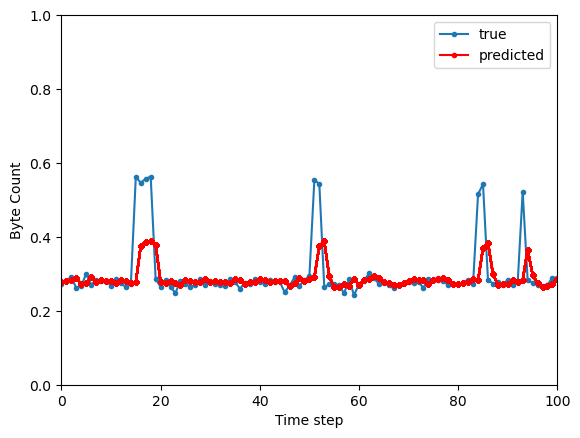

In [50]:
plt.xlim(0,100)
plt.ylim(0,1.0)
plt.plot(y_test_2, marker='.', label='true')
plt.plot(y_pred_sm, 'r', marker='.', label='predicted')
plt.ylabel('Byte Count')
plt.xlabel('Time step')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

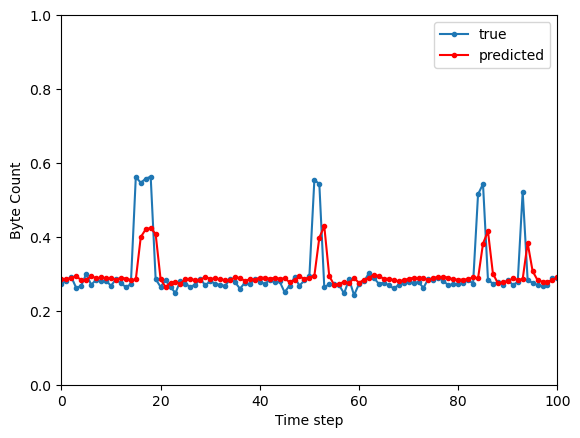

In [60]:
plt.xlim(0,100)
plt.ylim(0,1.0)
plt.plot(y_test_2, marker='.', label='true')
plt.plot(y_pred, 'r', marker='.', label='predicted')
plt.ylabel('Byte Count')
plt.xlabel('Time step')
plt.legend()

In [61]:
X_train_3, y_train_3 = batch(train_2, train_2['FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)
X_test_3, y_test_3 = batch(test_2, test_2['FromInternetUDPPort67IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)

history_from67 = model.fit(X_train_3, y_train_3,
                    epochs = 50,
                    batch_size = 64,
                    validation_split = 0.1,
                    shuffle = False)

Epoch 1/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0241 - val_loss: 0.0158
Epoch 2/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0132 - val_loss: 0.0135
Epoch 3/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0118 - val_loss: 0.0128
Epoch 4/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0115 - val_loss: 0.0123
Epoch 5/50
215/215 [==============================] - 2s 8ms/step - loss: 0.0112 - val_loss: 0.0121
Epoch 6/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0109 - val_loss: 0.0119
Epoch 7/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0108 - val_loss: 0.0117
Epoch 8/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0105 - val_loss: 0.0115
Epoch 9/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0103 - val_loss: 0.0113
Epoch 10/50
215/215 [==============================] - 2s 9ms/step - loss: 0.0102 - val_loss: 0.0110

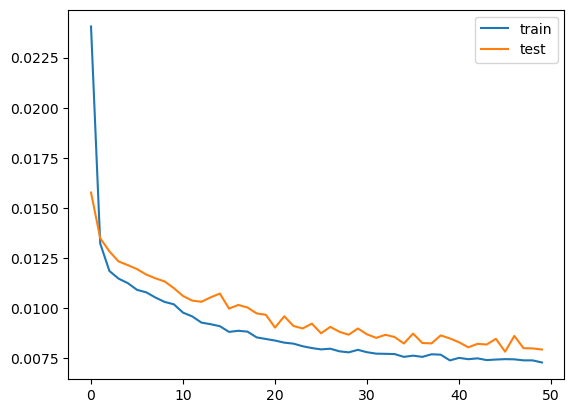

In [63]:
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend()
plt.show()

119/119 [==============================] - 0s 3ms/step


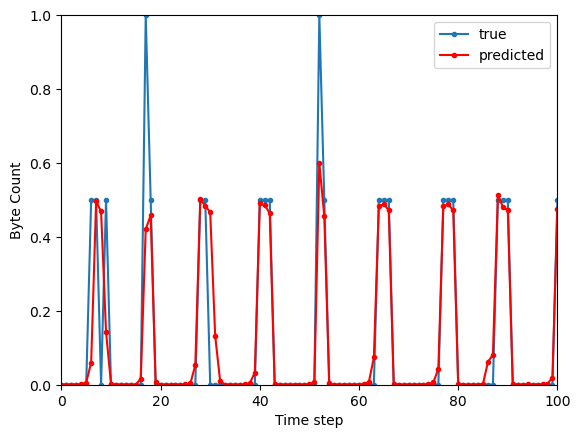

In [64]:
y_pred_67 = model.predict(X_test_3)

plt.xlim(0,100)
plt.ylim(0,1.0)
plt.plot(y_test_3, marker='.', label='true')
plt.plot(y_pred_67, 'r', marker='.', label='predicted')
plt.ylabel('Byte Count')
plt.xlabel('Time step')
plt.legend()

In [83]:
X_train_4, y_train_4 = batch(train_2, train_2['FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)
X_test_4, y_test_4 = batch(test_2, test_2['FromInternetTCPPort80IPurn:ietf:params:mud:controllerByteCount'], time_steps=TIME)

history_from80 = model.fit(X_train_4, y_train_4,
                    epochs = 50,
                    batch_size = 64,
                    validation_split = 0.1,
                    shuffle = False)

Epoch 1/50
215/215 [==============================] - 2s 9ms/step - loss: 6.2951e-04 - val_loss: 1.6212e-05
Epoch 2/50
215/215 [==============================] - 2s 9ms/step - loss: 3.9984e-05 - val_loss: 1.5771e-05
Epoch 3/50
215/215 [==============================] - 2s 9ms/step - loss: 3.1825e-05 - val_loss: 1.5398e-05
Epoch 4/50
215/215 [==============================] - 2s 9ms/step - loss: 1.1843e-05 - val_loss: 1.5367e-05
Epoch 5/50
215/215 [==============================] - 2s 9ms/step - loss: 1.0342e-05 - val_loss: 1.5363e-05
Epoch 6/50
215/215 [==============================] - 2s 9ms/step - loss: 9.0365e-06 - val_loss: 1.5360e-05
Epoch 7/50
215/215 [==============================] - 2s 9ms/step - loss: 1.0541e-05 - val_loss: 1.5358e-05
Epoch 8/50
215/215 [==============================] - 2s 9ms/step - loss: 8.0387e-06 - val_loss: 1.5356e-05
Epoch 9/50
215/215 [==============================] - 2s 9ms/step - loss: 7.1681e-06 - val_loss: 1.5355e-05
Epoch 10/50
215/215 [=======

119/119 [==============================] - 0s 3ms/step


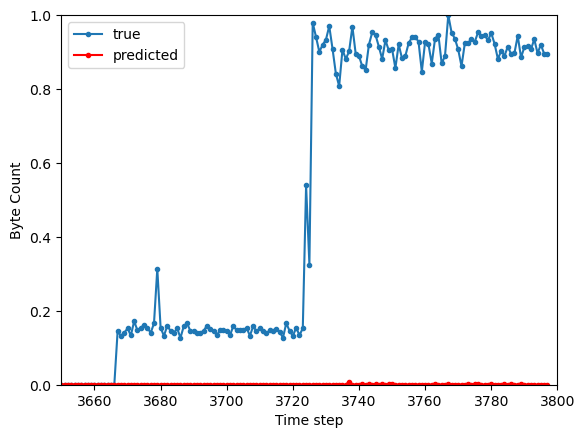

In [88]:
y_pred_from87 = model.predict(X_test_4)

plt.xlim(3650, 3800)
plt.ylim(0,1.0)
plt.plot(y_test_4, marker='.', label='true')
plt.plot(y_pred_from87, 'r', marker='.', label='predicted')
plt.ylabel('Byte Count')
plt.xlabel('Time step')
plt.legend()